# KJM ECoG Fingerflex Dataset

Two of the datasets we have prepared for the workshop come from Kai Miller's ECoG data repository.
* [Miller, KJ. A library of human electrocorticographic data and analyses. Nature Human Behaviour, 2019](https://www.nature.com/articles/s41562-019-0678-3)
* [Direct Data Repository Link](https://searchworks.stanford.edu/view/zk881ps0522)

If you want the full raw data from the entire repository then you can use the scripts in this workshop's data/kjm_ecog folder.
If you are satisfied using somewhat preprocessed data then you can proceed below and the data will be downloaded on demand.

In this notebook we will explore the "Fingerflex" study data.
The data originally appeared in the [manuscript](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002655)
"Human Motor Cortical Activity Is Selectively Phase-Entrained on Underlying Rhythms", published in PLoS Computational Biology in 2012.

A portion of the dataset composes the [BCI Competition IV Dataset 4](http://www.bbci.de/competition/iv/#dataset4).


## Prepare the notebook
The next cell is to normalize local environments and Google Colaboratory environments.
If you're running this on Colab, then a widget will appear asking you to upload your [kaggle API auth token](https://www.kaggle.com/docs/api#authentication).
This is normally found in `~/.kaggle/kaggle.json` where `~` is your Home directory. You may need to make visible
hidden files or folders before you can find the file in explorer.
If you're running this locally then please make sure the kaggle.json file is in the expected location.

In [1]:
from pathlib import Path
import os
import matplotlib.pyplot as plt


try:
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
            
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    
    !pip install -q kaggle
    plt.style.use('dark_background')
    IN_COLAB = True
    
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")
        

import numpy as np
from indl import turbo_cmap, reset_keras
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 10,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'legend.loc': 'best',
    'figure.figsize': [10, 8]
})
%load_ext autoreload
%autoreload 2

## Download Data
Run the next cell to download and unzip the data. Compared to the original data from the data repository,
the files in the Kaggle Dataset have had some additional preprocessing.

The downloaded data contain 3 files for each of the 9 subjects:
* subname_full.h5 - Bad channel removal, common average referencing, 60 Hz notch filter.
* subname_segs.h5 - Same as _full but the data have been segmented from -0.75 to +0.75 s around the onset of (human-coded) finger-flexion events.
* subname_bp.h5 - _full with spectral whitening, filterbank (6th order Butter filtfilt) at alpha, beta, and broadband frequencies,
power in each band downsampled to 20 Hz, zscored, segmented as in _segs.

In [2]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' / 'fingerflex')} cboulay/kjm-ecog-fingerflex
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Import one subject's data
The data have been stored as HDF5 files and thus can be imported directly into Python.
However, to make your life a little easier, we wrote a small function that makes importing slightly friendlier.

In [3]:
from data.utils.fileio import load_fingerflex


SUB_ID = 'cc'
X, Y, ax_info, behav = load_fingerflex(datadir, SUB_ID, feature_set='full', event_set='Stim')
tvec = ax_info['timestamps']
srate = ax_info['fs']
print(f"Found {len(tvec)} timestamps ({tvec[0]} to {tvec[-1]} s at {srate} Hz), {X.shape[-1]} chans")

Found 610040 timestamps (0.0 to 610.039 s at 1000.0 Hz), 60 chans


## Examine data

Let's plot a segment of neural data (only every 10th channel) and behavioural data overlaid with events.
Since we used `event_set='Stim'` in the call to `load_fingerflex`, the events
are human-coded markers for when a particular finger movement started.
Had we used `event_set='Cue'` instead, then the events would be when the visual instruction appeared on-screen.

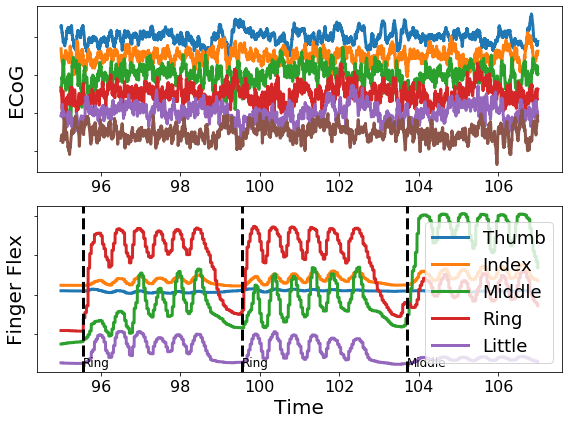

In [4]:
t_range = [95, 107.0]
b_times = np.logical_and(tvec >= t_range[0], tvec <= t_range[1])

plt.figure(figsize=(8, 6))

# Plot neural data, only a few channels otherwise it's too noisy.
ax1 = plt.subplot(2, 1, 1)
plt_dat = X[b_times, ::10]
chan_offsets = -100 * np.arange(plt_dat.shape[-1])[None, :]
ax1.plot(tvec[b_times], plt_dat + chan_offsets)
ax1.set_yticklabels([])
ax1.set_ylabel('ECoG')
ax1.patch.set_alpha(0.0)

# Plot behavioural data
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
chan_offsets = -200 * np.arange(behav.shape[-1])[None, :]
for fing_ix in range(behav.shape[-1]):
    ax2.plot(tvec[b_times], behav[b_times, fing_ix] + chan_offsets[:, fing_ix],
             label=ax_info['behav_channel_names'][fing_ix])
ax2.set_xlabel('Time')
ax2.set_yticklabels([])
ax2.set_ylabel('Finger Flex')
ax2.patch.set_alpha(0.0)
ax2.legend(loc='lower right')

# Overlay events
y_t = ax_info['instance_times']
b_y = np.logical_and(y_t >= t_range[0], y_t <= t_range[1])
for ev_ix, ev_name in enumerate(Y[b_y, 0]):
    x = y_t[b_y][ev_ix]
    ax2.axvline(x, color='k', linestyle='--')
    ax2.annotate(ev_name, (x, 600), fontsize='large')

plt.tight_layout()

### Examine Segments

One could be interested in analyzing these continuous data using dynamical systems modeling (e.g., KF, RNN),
perhaps to find a relationship between neural dynamics and movement dynamics.

However, in this document we're going to analyze a segment of data around each event as a discrete instance.
Each instance has an associated class: the cued finger or the primary finger movement in that period.

Note: For some neural features that we may want to extract from the ECoG signal, it is preferable to calculate the
continuous feature on the continuous time series first, then segment the feature. We'll deal with that later.

In [5]:
SEG_WINDOW = [-0.1, 0.9]  # Window, in seconds, around each event.and

# Build a matrix of timestamp indices that capture our window around each event.
rel_samp_inds = np.arange(int(np.diff(SEG_WINDOW) * srate)) + int(SEG_WINDOW[0] * srate)  # within-window indices.
ev_0_inds = np.searchsorted(tvec, ax_info['instance_times'])  # timestamp indices of each event.
ev_inds = ev_0_inds[:, None] + rel_samp_inds[None, :]  # None adds an empty dim, required for broadcast-add.

seg_X = X[ev_inds, :]  # trials x samples x channels
seg_behav = behav[ev_inds, :]
seg_t = rel_samp_inds / srate


For a subset of these events, and a subset of the channels, let's plot
the average event-related potential (ERP),
and the average power spectral density (converted to decibels with log transform).

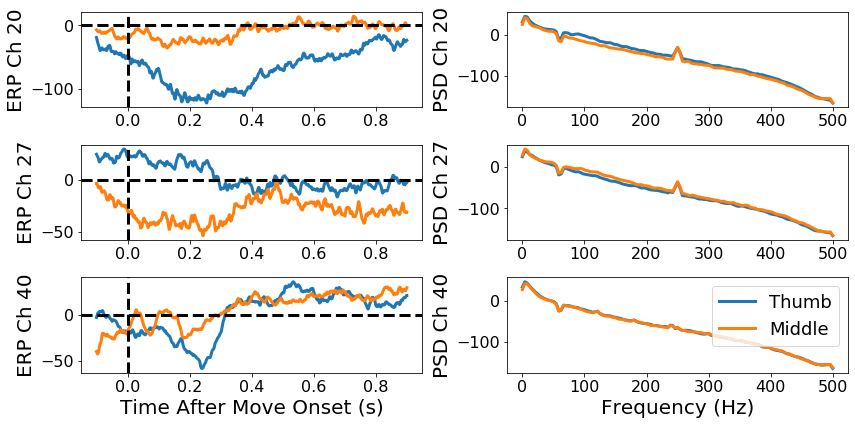

In [6]:
VIS_EVENTS = ['Thumb', 'Middle']  # Choose event types to use for visualization.
CH_INDS = [20, 27, 40]            # Choose a set of channels to visualize.  19, 20, 27, 40

plt.figure(figsize=(12, 6))

axes = []
for sp_ix, ch_ix in enumerate(CH_INDS):
    if len(axes) > sp_ix:
        axes.append(plt.subplot(len(CH_INDS), 2, 2 * sp_ix + 1, sharex=axes[0]))
    else:
        axes.append(plt.subplot(len(CH_INDS), 2, 2 * sp_ix + 1))
    for ev_name in VIS_EVENTS:
        b_ev = Y[:, 0] == ev_name
        # Calculate the event-related potential. This would be a better idea if the data were time-locked
        # to stimulus-onset, instead of movement-onset which is a bit of a fuzzier 'event' in the brain.
        erp = np.mean(seg_X[b_ev, :, ch_ix], axis=0)
        axes[sp_ix].plot(seg_t, erp, label=ev_name)
    axes[sp_ix].axvline(0, color='k', linestyle='--')
    axes[sp_ix].axhline(0, color='k', linestyle='--')
    axes[sp_ix].set_ylabel(f'ERP Ch {ch_ix}')
axes[-1].set_xlabel('Time After Move Onset (s)')

# Calculate and plot spectral power in each window averaged over trials within each condition.
import scipy.signal
axes = []
for sp_ix, ch_ix in enumerate(CH_INDS):
    if len(axes) > sp_ix:
        axes.append(plt.subplot(len(CH_INDS), 2, 2 * sp_ix + 2, sharex=axes[0]))
    else:
        axes.append(plt.subplot(len(CH_INDS), 2, 2 * sp_ix + 2))
    for ev_name in VIS_EVENTS:
        b_ev = Y[:, 0] == ev_name
        # Calculate the spectrum.
        f, Pxx = scipy.signal.welch(seg_X[b_ev, :, ch_ix], fs=srate, detrend='linear', axis=1)
        Pxx = np.mean(10 * np.log(Pxx), axis=0)
        axes[sp_ix].plot(f, Pxx, label=ev_name)
    axes[sp_ix].set_ylabel(f'PSD Ch {ch_ix}')
axes[-1].legend(loc='upper right')
axes[-1].set_xlabel('Frequency (Hz)')

plt.tight_layout()

From the above plots we can see that there are some differences in the evoked potential during different movement conditions,
and there are differences between the spectral power in the 50-200 Hz range.
In fact this latter signal feature is perhaps the most common signal feature used in ECoG based BCI decoders.

### Extracting Broadband Power

There are many methods to extract features from the ECoG signal that correspond to the broadband power
from 50-200+ Hz.
One approach is to:
(1) segment your signals into time windows,
(2) calculate the FFT in each window to get its spectrum,
(3) convert spectral power to dB with a log transform,
(4) slice the spectrum in the frequencies of interest,
(5) average over all kept frequencies.
Usually between steps 2 and 3 there is another step to normalize the spectrum across frequencies,
to help compensate for the 1/f falloff found in biological signals.
The windowing can vary quite a bit, sometimes using only 1 window per trial, or sometimes using
multiple windows per trial, yielding a time-frequency or spectrogram.

Another approach, and indeed the [approach we used](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/data/kjm_ecog/03_convert.py#L126-L175),
is to:
(1) bandpass filter your data to pass only frequencies of interest,
(2) take (overlapping) windows,
(3) calculate variance within each window,
(4) take the logarithm,
(5) z-score across all trials (helpful for ML). 
As an alternative to steps (2) and (3), one could use the hilbert transform to get the analytic signal,
then take the abs of the analytic signal to get the instantaneous amplitude.

We've already done this second approach, so let's simply import that data.
Notice the `feature_set='bp'` parameter.

In [7]:
X, Y, ax_info, behav = load_fingerflex(datadir, SUB_ID, feature_set='bp', event_set='Stim')
tvec = ax_info['timestamps']
srate = ax_info['fs']
chan_names= ax_info['channel_names']
fvec = ax_info['frequencies']
print(f"Found {len(Y)} trials, {len(tvec)} timestamps ({tvec[0]} to {tvec[-1]} s at {srate} Hz), ")
print(f"{len(chan_names)} chans, and {len(fvec)} freqs ({fvec} Hz).")
print("Keeping only last frequency.")
X = X[:, :, :, -1]

Found 267 trials, 31 timestamps (-0.75 to 0.75 s at 20.0 Hz), 
60 chans, and 3 freqs ([ 11.  23. 175.] Hz).
Keeping only last frequency.


## Classification

### Drop trials with insufficient repetitions

As we'll be doing stratified K-fold cross-validation, we should first make sure that
each of our classes is represented at least once.
We'll also drop the 'ISI' trials because they are over-represented in the data
and inflate our classification accuracy.

In [8]:
K = 10  # K-fold cross-validation 
uq_labels, label_counts = np.unique(Y, return_counts=True)
drop_labels = uq_labels[label_counts < K].tolist()
drop_labels += ['ISI']
for label in  drop_labels:
    b_drop = Y[:, 0] == label
    if np.any(b_drop):
        Y = Y[~b_drop, 0]
        X = X[~b_drop, :, :]
        ax_info['instance_times'] = ax_info['instance_times'][~b_drop]
        ax_info['instance_data'] = ax_info['instance_data'][~b_drop]
        print(f"Dropped {np.sum(b_drop)} trials with label {label}.")

Dropped 114 trials with label ISI.


### Regularized logistic regression

We now have a whole bunch of features (31 timestamps * N channels) for each trial.
While it would probably be better to further reduce the features (e.g., using PCA),
let's go ahead and use some machine-learning to classify our data.
We'll use regularized logistic regression, and hope that the regularization will guard sufficiently
against over-fitting, despite having so many features and not so many realizations.

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

kwargs = {
    'solver': 'lbfgs',
    'C': 300.0,  # inverse regularization strength
    'penalty': 'l2',  # ‘l1’, ‘l2’, ‘elasticnet’ or ‘none’
    'multi_class': 'ovr',  # One-vs-rest
    'class_weight': 'balanced',
    'max_iter': 200
}

model = LogisticRegression(**kwargs)
splitter = StratifiedKFold(n_splits=K)

y_preds = []
y_true = []
coefs = []
print(f"Performing {K}-fold cross-validated logistic regression...")
for kfold, (trn, tst) in enumerate(splitter.split(X, Y)):
    print(f"Fold {kfold + 1}")
    _x = X[trn].reshape(-1, np.prod(X.shape[1:]))
    model.fit(_x, Y[trn].ravel())
    _x_tst = X[tst].reshape(-1, np.prod(X.shape[1:]))
    y_preds.append(model.predict(_x_tst))
    y_true.append(Y[tst].ravel())
    coefs.append(model.coef_)

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("5-class accuracy: %{:.2f}".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
5-class accuracy: %73.20


### Confusion Matrix

One way to get a good feeling for how your errors are distributed is by plotting a confusion matrix.
TODO: Resort in correct finger order.

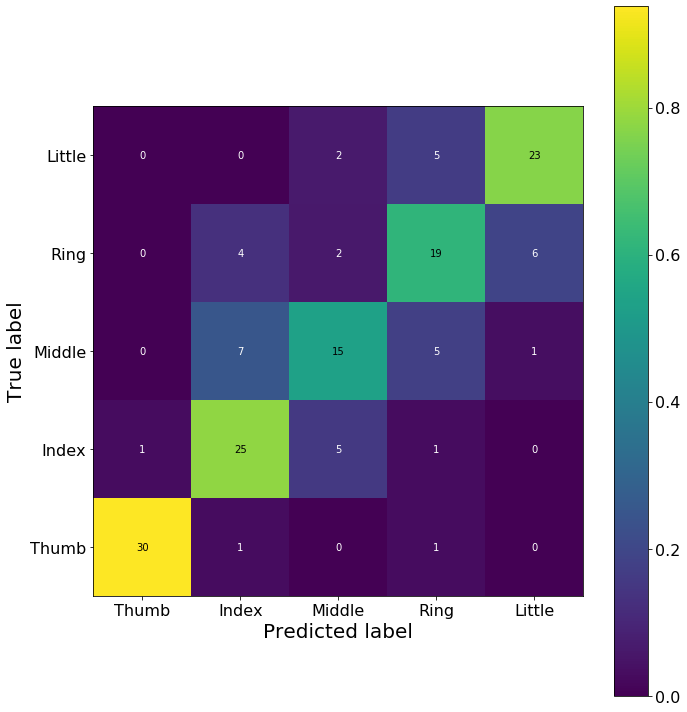

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

cm = confusion_matrix(y_true, y_preds)
classes = unique_labels(y_true, y_preds)

# Sort the classes in a more meaningful order
class_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Little']
re_ix = [classes.tolist().index(_) for _ in class_names]
cm = cm[re_ix, :][:, re_ix]
classes = classes[re_ix]

cm_int = np.copy(cm)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
im = ax.imshow(cm, interpolation='nearest', origin='upper')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
      yticks=np.arange(cm.shape[0]),
      # ... and label them with the respective list entries
      xticklabels=classes, yticklabels=classes,
      ylabel='True label',
      xlabel='Predicted label',
    ylim=(-0.5, 4.5))

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_int[i, j], 'd'),
                ha="center", va="center",
                color="black" if cm[i, j] > thresh else "white")
plt.tight_layout()

### Visualize Weights

Now we can look at the weights that the model(s) learned to predict each class.
The features included all channels at all time points, so the spatial filter (i.e., the contribution across channels) changes over time.

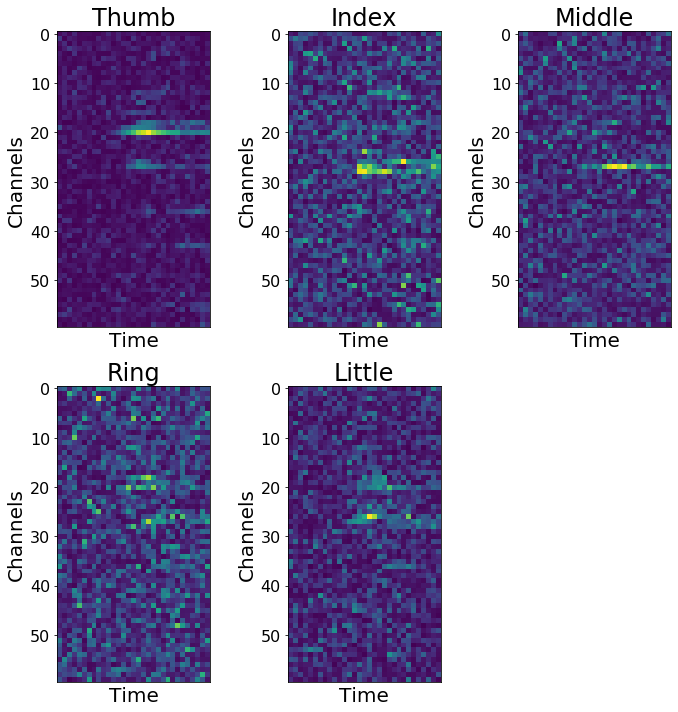

In [11]:
weights = np.stack(coefs, axis=-1)
weights = np.mean(np.abs(weights), axis=-1)  # abs to get magnitude, not direction.
weights = np.reshape(weights, (len(classes),) + X.shape[1:])
weights = weights[re_ix]

plt.figure(figsize=(10, 10))

for class_ix, class_name in enumerate(class_names):
    plt.subplot(2, 3, class_ix + 1)
    plt.imshow(weights[class_ix].T, interpolation='nearest')
    plt.title(class_name)
    plt.ylabel('Channels')
    plt.xlabel('Time')
    plt.xticks([])
plt.tight_layout()

In [12]:
# Read in brain geometry to get vertices (x,y,z)
# and faces (indices of 3 corners of each triangle)
# Note: If using freesurfer, can use nibabel.freesurfer import read_geometry
brain_path = datadir / 'converted' / 'fingerflex' / (SUB_ID + '_brain.npz')
npzfile = np.load(brain_path)
tris = npzfile['tris']
verts = npzfile['verts']
chan_xyz = ax_info['channel_locs']
chan_weights = np.mean(weights[:, 12:22, :], axis=1)

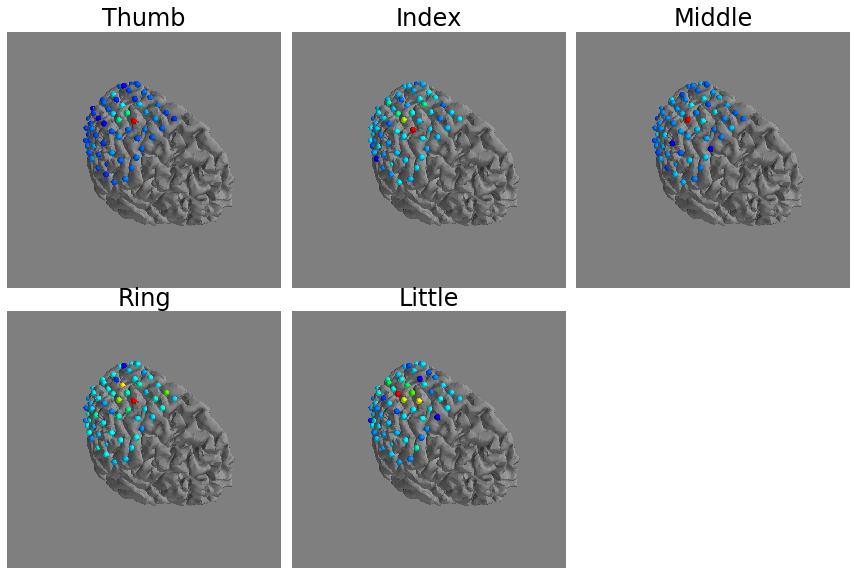

In [41]:
# plot brain with Mayavi
from mayavi import mlab

fig = mlab.figure(size=(800,800))
if hasattr(getattr(fig.scene, 'renderer', None), 'use_fxaa'):
    fig.scene.renderer.use_fxaa = True
plt.figure(figsize=(12, 8))
    
for class_ix, class_name in enumerate(class_names):
    surface = mlab.triangular_mesh(verts[:, 0], verts[:, 1], verts[:, 2],
                                   tris-1,
                                   color=(0.5, 0.5, 0.5),
                                   figure=fig)
    mlab.points3d(chan_xyz[:, 0], chan_xyz[:, 1], chan_xyz[:, 2], chan_weights[class_ix],
                  scale_factor=5.0, scale_mode='none', figure=fig)
    fig.scene._lift()
    imgmap = mlab.screenshot(figure=fig, mode='rgba', antialiased=True)
    mlab.clf(fig)
    
    ax = plt.subplot(2, 3, class_ix + 1)
    ax.imshow(imgmap, zorder=4)
    ax.patch.set_alpha(0.0)
    ax.axis('off')
    ax.set_title(class_name)
    
mlab.close(fig)
plt.tight_layout()

In [12]:
# TODO: plot brain mesh and electrode spheres with plotly
# I can't seem to get it to work with the provided tris
if False:
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go

    num_rows = 3
    num_cols = 2
    fig = make_subplots(
        rows=num_rows, cols=num_cols,
        specs=[[{'type': 'mesh3d'}]*num_cols]*num_rows,  # mesh3d
        shared_xaxes=True,  # Hack to get the func to auto-calculate axis locs for 3d
        print_grid=False,
        vertical_spacing=0,
        horizontal_spacing=0
    )

    for class_ix, class_name in enumerate(class_names):
        col_ix = (class_ix % num_cols) + 1
        row_ix = class_ix // num_cols + 1
        fig.add_trace(
            go.Mesh3d(
                # Use simple tetrahedrons for debugging:
                x=[0, 1, 2, 0], y=[0, 0, 1, 2], z=[0, 2, 0, 1],
                i=[0, 0, 0, 1], j=[1, 2, 3, 2], k=[2, 3, 1, 3],
                #x=verts[:, 0], y=verts[:, 1], z=verts[:, 2],
                #i=tris[:, 0], j=tris[:, 1], k=tris[:, 2],
                showscale=False,
                name=class_name
            ),
            row=row_ix, col=col_ix
        )

    fig.update_layout(
        hovermode='closest',
        showlegend=False,
        height=800,
        width=800
    )

    # pycharm needs fig.show(renderer="png")
    fig.show()